In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pycbc
from pycbc.frame import read_frame
from pycbc.catalog import Merger
from lal import LIGOTimeGPS
from pycbc import waveform
from pycbc.pnutils import f_SchwarzISCO
from pycbc.types import TimeSeries
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.psd import interpolate, welch, inverse_spectrum_truncation
from pycbc.filter import highpass, matched_filter

In [4]:
fLow, segLen = 20, 360
fSamp = 4096
m1, m2 = 1.41, 1.35
s1z, s2z = 0.0004, 0.0004
distance = 45
inclination = 2.5
f_final = f_SchwarzISCO(m1+m2)

merger = Merger("GW170817")
strain, stilde = {}, {}
ifos = ['L1', 'H1', 'V1']
fLow = 20 
fHigh = f_SchwarzISCO(m1+m2)

low_frequency_cutoff = {}
high_frequency_cutoff = {}

for ifo in ifos:
    
    low_frequency_cutoff[ifo] = fLow
    high_frequency_cutoff[ifo] = fHigh
    
#-- reading the data ---
for ifo in ifos:
    
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                   start_time=merger.time - 342,   
                   end_time=merger.time + 30,     
                   check_integrity=False)
    
    # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 18, filter_order=4)
    
    # Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(6,6)

    # Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()


#-- calculating psds ---

psds = {}

for ifo in ifos:
    # Calculate a psd from the data. We'll use 2s segments in a median - welch style estimate
    # We then interpolate the PSD to the desired frequency step. 
    psds[ifo] = interpolate(strain[ifo].psd(2), stilde[ifo].delta_f)

    # We explicitly control how much data will be corrupted by overwhitening the data later on
    # In this case we choose 2 seconds.
    psds[ifo] = inverse_spectrum_truncation(psds[ifo], int(2 * strain[ifo].sample_rate),
                                    low_frequency_cutoff=low_frequency_cutoff[ifo], trunc_method='hann')

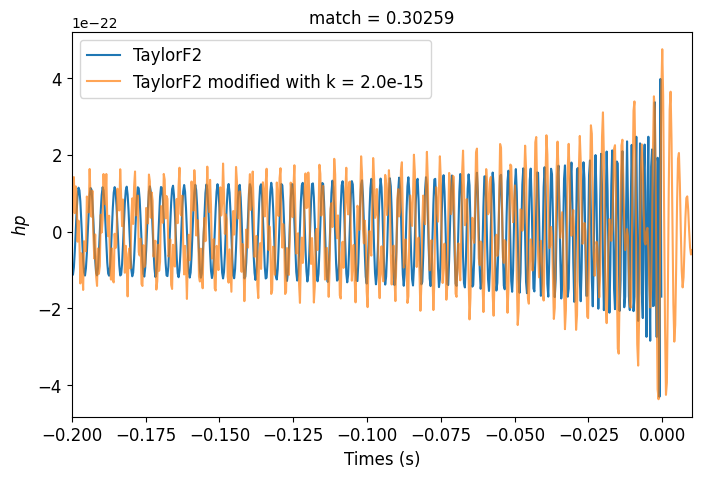

In [5]:
params = {'mass1': m1, 'mass2': m2, 'spin1z': s1z, 'spin2z': s2z, 'distance': distance, \
                      'f_lower': fLow, 'segLen': segLen, 'inclination': inclination}

# k = 1.7e-7
k = 2e-6

hp, hc = waveform.get_fd_waveform(approximant='TaylorF2', delta_f = 1/params['segLen'], **params)

hp_mod, hc_mod = waveform.get_fd_waveform(approximant='TaylorF2_full', k = k, \
                                                          delta_f = 1/params['segLen'], **params)

hp_td, hc_td = hp.to_timeseries(), hc.to_timeseries()
hp_td_mod, hc_td_mod = hp_mod.to_timeseries(), hc_mod.to_timeseries()

# for aligning the peaks
hp_td_mod.start_time += LIGOTimeGPS(-hp_td_mod.sample_times.data[np.argmax(abs(hp_td_mod.data))])
hc_td_mod.start_time += LIGOTimeGPS(-hc_td_mod.sample_times.data[np.argmax(abs(hc_td_mod.data))])

# match calculation
match_value = pycbc.filter.matchedfilter.match(hp_mod, hp, psd=psds[ifos[0]])[0] # calculated using psd from 'L1'

plt.figure(figsize=(8,5))

fontsize = 12

plt.plot(hp_td.sample_times, hp_td, label='TaylorF2')
plt.plot(hp_td_mod.sample_times, hp_td_mod, alpha=0.7, label='TaylorF2 modified with k = %.1e'%(k*1e-9))
plt.tick_params(which='both', labelsize=fontsize)
plt.xlim(-0.2, 0.01)
plt.xlabel('Times (s)', fontsize=fontsize)
plt.ylabel(r'$hp$', fontsize=fontsize)
plt.title('match = %.5f'%match_value, fontsize=fontsize)
plt.legend(fontsize=fontsize)
# plt.savefig('waveform.jpeg', dpi=100, bbox_inches='tight', pad_inches=0.05)
plt.show()

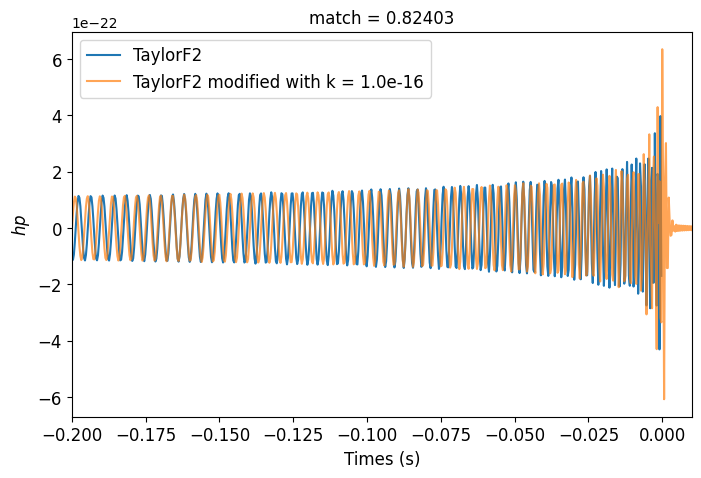

In [6]:
params = {'mass1': m1, 'mass2': m2, 'spin1z': s1z, 'spin2z': s2z, 'distance': distance, \
                      'f_lower': fLow, 'segLen': segLen, 'inclination': inclination}

k = 1e-7
# k = 6.6e-7

hp, hc = waveform.get_fd_waveform(approximant='TaylorF2', delta_f = 1/params['segLen'], **params)

hp_mod, hc_mod = waveform.get_fd_waveform(approximant='TaylorF2_full', k = k, \
                                                          delta_f = 1/params['segLen'], **params)

hp_td, hc_td = hp.to_timeseries(), hc.to_timeseries()
hp_td_mod, hc_td_mod = hp_mod.to_timeseries(), hc_mod.to_timeseries()

# for aligning the peaks
hp_td_mod.start_time += LIGOTimeGPS(-hp_td_mod.sample_times.data[np.argmax(abs(hp_td_mod.data))])
hc_td_mod.start_time += LIGOTimeGPS(-hc_td_mod.sample_times.data[np.argmax(abs(hc_td_mod.data))])

# match calculation
match_value = pycbc.filter.matchedfilter.match(hp_mod, hp, psd=psds[ifos[0]])[0] # calculated using psd from 'L1'

plt.figure(figsize=(8,5))

fontsize = 12

plt.plot(hp_td.sample_times, hp_td, label='TaylorF2')
plt.plot(hp_td_mod.sample_times, hp_td_mod, alpha=0.7, label='TaylorF2 modified with k = %.1e'%(k*1e-9))
plt.tick_params(which='both', labelsize=fontsize)
plt.xlim(-0.2, 0.01)
plt.xlabel('Times (s)', fontsize=fontsize)
plt.ylabel(r'$hp$', fontsize=fontsize)
plt.title('match = %.5f'%match_value, fontsize=fontsize)
plt.legend(fontsize=fontsize)
# plt.savefig('waveform.jpeg', dpi=100, bbox_inches='tight', pad_inches=0.05)
plt.show()

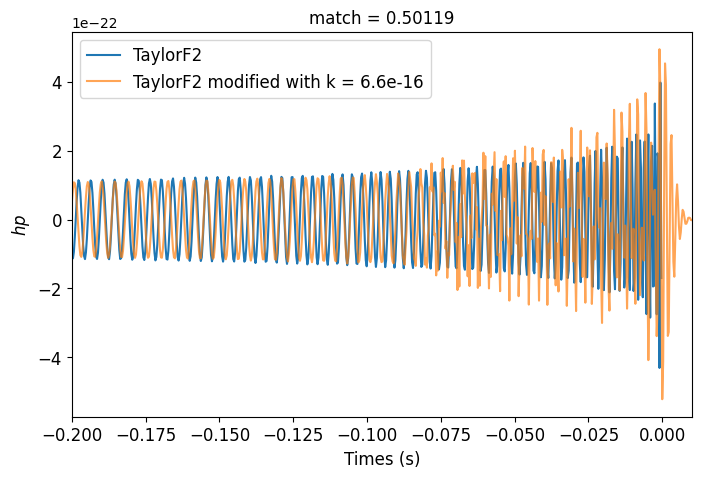

In [7]:
params = {'mass1': m1, 'mass2': m2, 'spin1z': s1z, 'spin2z': s2z, 'distance': distance, \
                      'f_lower': fLow, 'segLen': segLen, 'inclination': inclination}

# k = 1e-7
k = 6.6e-7

hp, hc = waveform.get_fd_waveform(approximant='TaylorF2', delta_f = 1/params['segLen'], **params)

hp_mod, hc_mod = waveform.get_fd_waveform(approximant='TaylorF2_full', k = k, \
                                                          delta_f = 1/params['segLen'], **params)

hp_td, hc_td = hp.to_timeseries(), hc.to_timeseries()
hp_td_mod, hc_td_mod = hp_mod.to_timeseries(), hc_mod.to_timeseries()

# for aligning the peaks
hp_td_mod.start_time += LIGOTimeGPS(-hp_td_mod.sample_times.data[np.argmax(abs(hp_td_mod.data))])
hc_td_mod.start_time += LIGOTimeGPS(-hc_td_mod.sample_times.data[np.argmax(abs(hc_td_mod.data))])

# match calculation
match_value = pycbc.filter.matchedfilter.match(hp_mod, hp, psd=psds[ifos[0]])[0] # calculated using psd from 'L1'

plt.figure(figsize=(8,5))

fontsize = 12

plt.plot(hp_td.sample_times, hp_td, label='TaylorF2')
plt.plot(hp_td_mod.sample_times, hp_td_mod, alpha=0.7, label='TaylorF2 modified with k = %.1e'%(k*1e-9))
plt.tick_params(which='both', labelsize=fontsize)
plt.xlim(-0.2, 0.01)
plt.xlabel('Times (s)', fontsize=fontsize)
plt.ylabel(r'$hp$', fontsize=fontsize)
plt.title('match = %.5f'%match_value, fontsize=fontsize)
plt.legend(fontsize=fontsize)
# plt.savefig('waveform.jpeg', dpi=100, bbox_inches='tight', pad_inches=0.05)
plt.show()

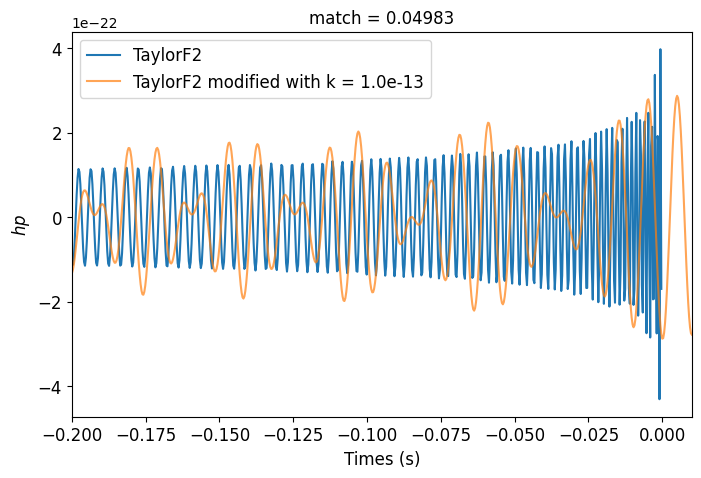

In [8]:
params = {'mass1': m1, 'mass2': m2, 'spin1z': s1z, 'spin2z': s2z, 'distance': distance, \
                      'f_lower': fLow, 'segLen': segLen, 'inclination': inclination}

k = 1e-4

hp, hc = waveform.get_fd_waveform(approximant='TaylorF2', delta_f = 1/params['segLen'], **params)

hp_mod, hc_mod = waveform.get_fd_waveform(approximant='TaylorF2_full', k = k, \
                                                          delta_f = 1/params['segLen'], **params)

hp_td, hc_td = hp.to_timeseries(), hc.to_timeseries()
hp_td_mod, hc_td_mod = hp_mod.to_timeseries(), hc_mod.to_timeseries()

# for aligning the peaks
hp_td_mod.start_time += LIGOTimeGPS(-hp_td_mod.sample_times.data[np.argmax(abs(hp_td_mod.data))])
hc_td_mod.start_time += LIGOTimeGPS(-hc_td_mod.sample_times.data[np.argmax(abs(hc_td_mod.data))])

# match calculation
match_value = pycbc.filter.matchedfilter.match(hp_mod, hp, psd=psds[ifos[0]])[0] # calculated using psd from 'L1'

plt.figure(figsize=(8,5))

fontsize = 12

plt.plot(hp_td.sample_times, hp_td, label='TaylorF2')
plt.plot(hp_td_mod.sample_times, hp_td_mod, alpha=0.7, label='TaylorF2 modified with k = %.1e'%(k*1e-9))
plt.tick_params(which='both', labelsize=fontsize)
plt.xlim(-0.2, 0.01)
plt.xlabel('Times (s)', fontsize=fontsize)
plt.ylabel(r'$hp$', fontsize=fontsize)
plt.title('match = %.5f'%match_value, fontsize=fontsize)
plt.legend(fontsize=fontsize)
# plt.savefig('waveform.jpeg', dpi=100, bbox_inches='tight', pad_inches=0.05)
plt.show()